In [1]:
import pandas as pd

SELECTED_COUNTRIES = [
    'AND', 'ARG', 'AUS', 'ARM', 'BGD', 'BOL', 'BRA', 'CAN', 'CHL', 'CHN', 'COL', 'CYP', 'CZE', 'ECU', 'EGY', 'ETH',
    'DEU', 'GRC', 'GBR', 'GTM', 'HKG', 'IRL', 'IDN', 'IND', 'IRN', 'IRQ', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'LBN',
    'LBY', 'MDV', 'MEX', 'MYS', 'MNG', 'MAR', 'MMR', 'NLD', 'NZL', 'NIC', 'NGA', 'PAK', 'PER', 'PHL', 'PRI', 'ROU',
    'RUS', 'SGP', 'SRB', 'SVK', 'KOR', 'TJK', 'THA', 'TUR', 'TUN', 'UKR', 'USA', 'URY', 'UZB', 'VEN', 'VNM', 'ZWE'
]

In [4]:
def clean_health_data(raw_path, output_path, countries=SELECTED_COUNTRIES):
    df = pd.read_csv(raw_path, skiprows=4)

    df = df[df['Country Code'].isin(countries)]

    years = [str(y) for y in range(1980, 2024)]
    df = df[['Country Name', 'Country Code'] + years]

    df_long = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name='Health_Expenditure'
    )

    df_long = df_long.rename(columns={
        'Country Name': 'Country',
        'Country Code': 'ISO3'
    })

    df_long['Year'] = df_long['Year'].astype(int)
    df_long = df_long.sort_values(by=['Country', 'Year']).reset_index(drop=True)

    df_long.to_csv(output_path, index=False)
    return df_long

In [ ]:
df_health = clean_health_data(
    '../data/raw/health_expenditure_raw.csv',
    '../data/interim/health_expenditure_1.csv' #Health Expenditure up to 2022
)
df_health

,Country,ISO3,Year,Health_Expenditure
0,Andorra,AND,1980,NaN
1,Andorra,AND,1981,NaN
2,Andorra,AND,1982,NaN
3,Andorra,AND,1983,NaN
4,Andorra,AND,1984,NaN
...,...,...,...,...
2811,Zimbabwe,ZWE,2019,3.232678
2812,Zimbabwe,ZWE,2020,2.954401
2813,Zimbabwe,ZWE,2021,2.785717
2814,Zimbabwe,ZWE,2022,3.628807


In [18]:
def GDP_percapita(raw_path, output_path, countries=SELECTED_COUNTRIES):
    df = pd.read_csv(raw_path, skiprows=4)

    df = df[df['Country Code'].isin(countries)]

    years = [str(y) for y in range(1960, 2024)]
    df = df[['Country Name', 'Country Code'] + years]

    df_long = df.melt(
        id_vars=['Country Name', 'Country Code'],
        var_name='Year',
        value_name='GDP_percapita'
    )

    df_long = df_long.rename(columns={
        'Country Name': 'Country',
        'Country Code': 'ISO3'
    })

    df_long['Year'] = df_long['Year'].astype(int)
    df_long = df_long.sort_values(by=['Country', 'Year']).reset_index(drop=True)

    df_long.to_csv(output_path, index=False)
    return df_long

In [19]:
df_gdp = GDP_percapita(
    '../data/raw/GDP_percapita.csv',
    '../data/interim/GDP_percapita_1.csv' #GDP percapita all year avail for selected countries
)
df_gdp

,Country,ISO3,Year,GDP_percapita
0,Andorra,AND,1960,NaN
1,Andorra,AND,1961,NaN
2,Andorra,AND,1962,NaN
3,Andorra,AND,1963,NaN
4,Andorra,AND,1964,NaN
...,...,...,...,...
4091,Zimbabwe,ZWE,2019,1684.027904
4092,Zimbabwe,ZWE,2020,1730.413489
4093,Zimbabwe,ZWE,2021,1724.387731
4094,Zimbabwe,ZWE,2022,2040.552459


In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# Load the data (you already did this)
df_gdp = pd.read_csv("../data/interim/GDP_percapita_1.csv")

# Store updated rows
projected_list = []

# Loop by country
for country, group in df_gdp.groupby("ISO3"):
    group = group.sort_values("Year").copy()

    # Training data: all available years < 2024 with non-missing GDP
    train = group[(group["Year"] < 2024) & (group["GDP_percapita"].notna())]

    if len(train) >= 5:  # Optional: require minimum data points
        X = train[["Year"]]
        y = np.log(train["GDP_percapita"])

        model = LinearRegression().fit(X, y)

        # Generate future years from 2024 to 2050
        future_years = list(range(2024, 2051))
        future_df = pd.DataFrame({
            "Country": group["Country"].iloc[0],
            "ISO3": country,
            "Year": future_years
        })

        # Predict log(GDP) and back-transform
        X_future = future_df[["Year"]]
        y_pred_log = model.predict(X_future)
        future_df["GDP_percapita"] = np.exp(y_pred_log)

        # Combine historical + future
        group = pd.concat([group, future_df], ignore_index=True)

    # Append
    projected_list.append(group)

# Final full dataset
df_gdp_projected = pd.concat(projected_list, ignore_index=True)

df_gdp_projected.to_csv("../data/interim/GDP_percapita_2.csv", index=False) #Projected to 2050 using long history from 1960

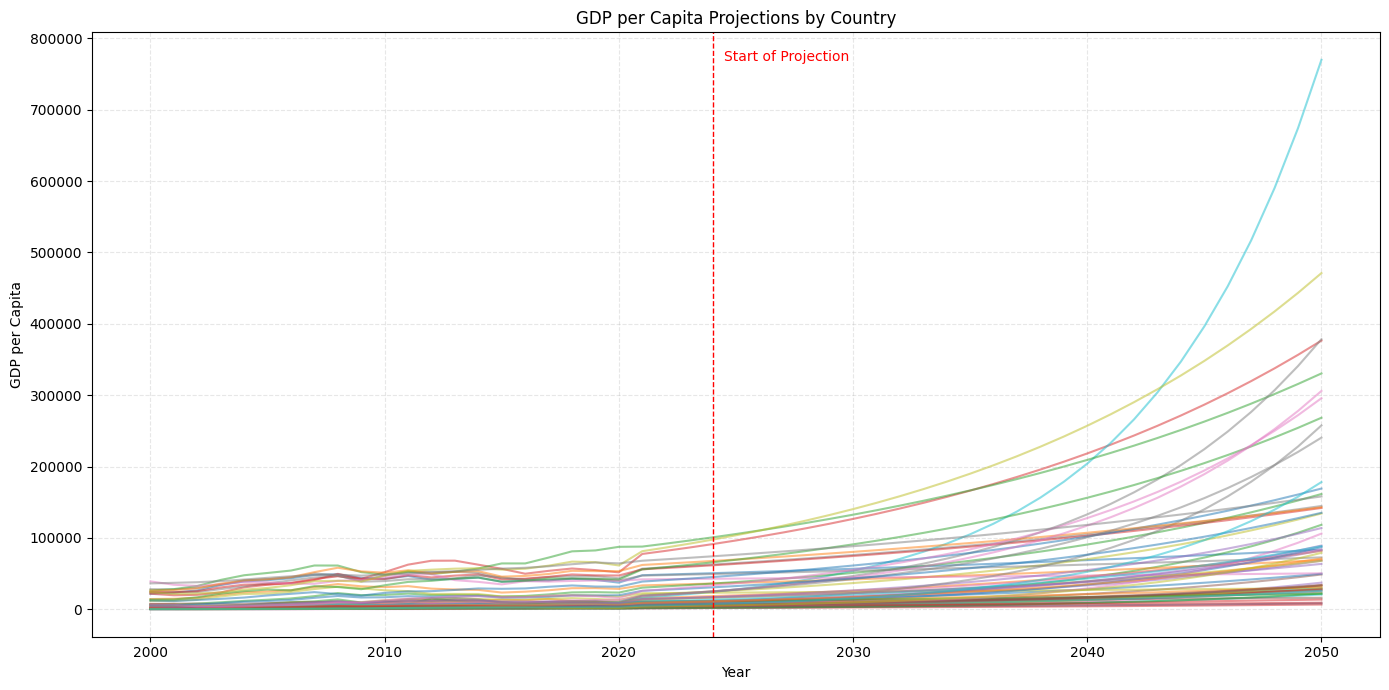

In [35]:
import matplotlib.pyplot as plt

# Load the projected dataset (if not already)
df = pd.read_csv("../data/interim/health_projection_3.csv")

# Plot
plt.figure(figsize=(14, 7))

for iso, group in df.groupby("ISO3"):
    plt.plot(group["Year"], group["GDP_percapita"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='red', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='red')

plt.title("GDP per Capita Projections by Country")
plt.xlabel("Year")
plt.ylabel("GDP per Capita")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [36]:
# Filter for the year 2050
df_2050 = df[df["Year"] == 2050].copy()

# Sort by GDP_percapita descending and get top 10
top10 = df_2050.sort_values("GDP_percapita", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "GDP_percapita"]])

                 Country ISO3  GDP_percapita
509                China  CHN  769926.516091
2498           Singapore  SGP  471071.096808
1376          Kazakhstan  KAZ  378464.697423
203            Australia  AUS  376541.374833
1223             Ireland  IRL  330502.609666
2345             Romania  ROU  305970.310295
2957             Uruguay  URY  295808.886165
2039         New Zealand  NZL  268431.667509
1835            Mongolia  MNG  257655.084221
2396  Russian Federation  RUS  240555.382313


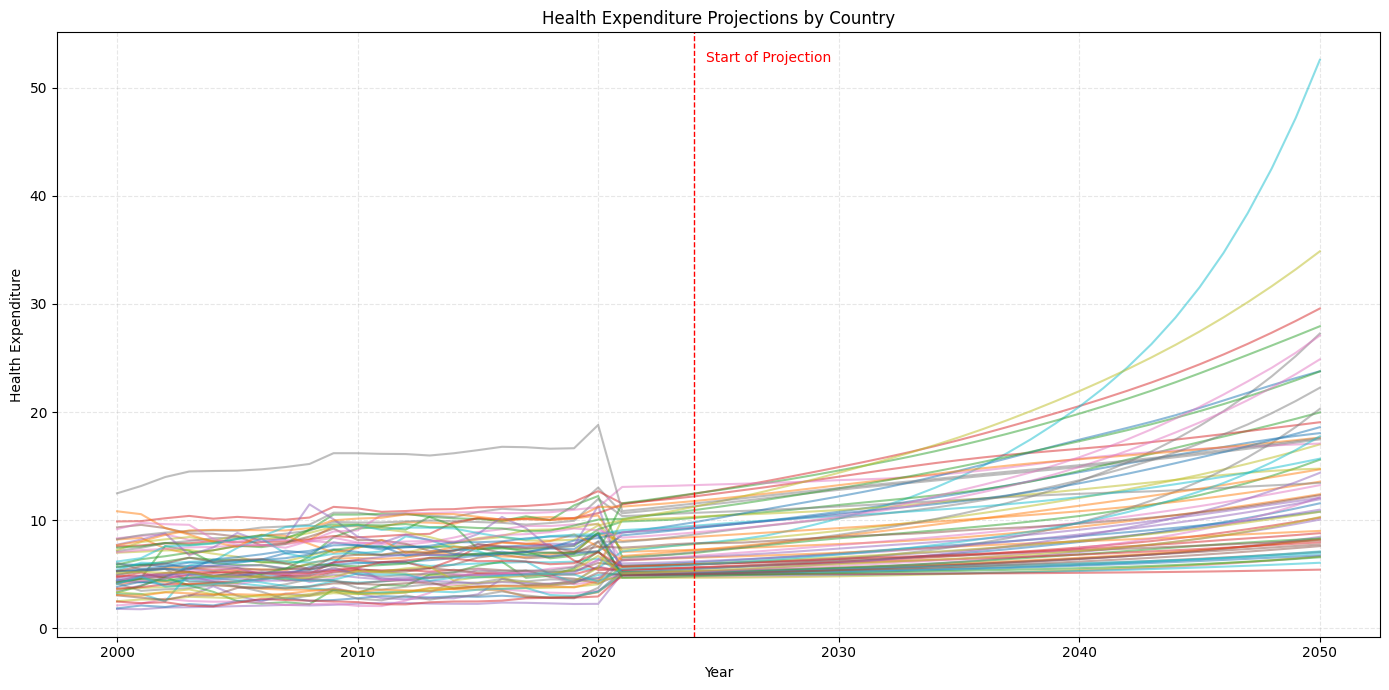

In [28]:
# Load the projected dataset (if not already)
df = pd.read_csv("../data/interim/health_projection_3.csv")

# Plot
plt.figure(figsize=(14, 7))

for iso, group in df.groupby("ISO3"):
    plt.plot(group["Year"], group["Health_Expenditure"], alpha=0.5)  # light lines

# Add vertical line to mark the start of projection (2024)
plt.axvline(x=2024, color='red', linestyle='--', linewidth=1)
plt.text(2024.5, plt.ylim()[1]*0.95, 'Start of Projection', color='red')

plt.title("Health Expenditure Projections by Country")
plt.xlabel("Year")
plt.ylabel("Health Expenditure")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Filter for the year 2050
df_2050 = df[df["Year"] == 2050].copy()

# Sort by Health Expenditure descending and get top 10
top10 = df_2050.sort_values("Health_Expenditure", ascending=False).head(10)

# Display result
print(top10[["Country", "ISO3", "Health_Expenditure"]])

                 Country ISO3  Health_Expenditure
509                China  CHN           52.571563
2498           Singapore  SGP           34.865716
203            Australia  AUS           29.578471
1223             Ireland  IRL           27.937114
1376          Kazakhstan  KAZ           27.265337
2345             Romania  ROU           27.078882
2957             Uruguay  URY           24.880158
1478         Korea, Rep.  KOR           23.777035
2039         New Zealand  NZL           23.763558
2396  Russian Federation  RUS           22.253652


In [1]:
import pandas as pd
import plotly.express as px

In [2]:
# Load your data
df = pd.read_csv("../data/interim/merged_data.csv")

df_filtered = df[(df["Year"] >= 2000) & (df["Year"] <= 2022)].copy()

In [3]:
# Define custom color and order for income levels
income_colors = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "yellow",
    "Low income": "red"
}
income_order = ["High income", "Upper middle income", "Lower middle income", "Low income"]

# Create animated scatter plot
fig = px.scatter(
    df_filtered,
    x="Dependency_Ratio",
    y="Health_Expenditure",
    animation_frame="Year",
    animation_group="Country",
    color="income_level",
    color_discrete_map=income_colors,
    category_orders={"income_level": income_order},
    hover_name="Country", 
    title="Health Expenditure vs. Dependency Ratio (2000–2022)",
    range_x=[df["Dependency_Ratio"].min() - 5, df["Dependency_Ratio"].max() + 5],
    range_y=[df["Health_Expenditure"].min() - 2, df["Health_Expenditure"].max() + 2]
)

# Style labels
fig.update_traces(textposition="top center", marker=dict(size=12))
fig.update_layout(legend_title_text="Income Level")

# Show the figure
fig.show()

In [4]:
# Create animated scatter plot
fig = px.scatter(
    df_filtered,
    x="Dependency_Ratio_Old",
    y="Health_Expenditure",
    animation_frame="Year",
    animation_group="Country",
    color="income_level",
    color_discrete_map=income_colors,
    category_orders={"income_level": income_order},
    hover_name="Country", 
    title="Health Expenditure vs. Dependency Ratio for Old Population (2000–2022)",
    range_x=[df["Dependency_Ratio_Old"].min() - 5, df["Dependency_Ratio_Old"].max() + 5],
    range_y=[df["Health_Expenditure"].min() - 2, df["Health_Expenditure"].max() + 2]
)

# Style labels
fig.update_traces(textposition="top center", marker=dict(size=12))
fig.update_layout(legend_title_text="Income Level")

# Show the figure
fig.show()

In [5]:
# Create animated scatter plot
fig = px.scatter(
    df_filtered,
    x="Dependency_Ratio_Young",
    y="Health_Expenditure",
    animation_frame="Year",
    animation_group="Country",
    color="income_level",
    color_discrete_map=income_colors,
    category_orders={"income_level": income_order},
    hover_name="Country", 
    title="Health Expenditure vs. Dependency Ratio for Youth Population (2000–2022)",
    range_x=[df["Dependency_Ratio_Young"].min() - 5, df["Dependency_Ratio_Young"].max() + 5],
    range_y=[df["Health_Expenditure"].min() - 2, df["Health_Expenditure"].max() + 2]
)

# Style labels
fig.update_traces(textposition="top center", marker=dict(size=12))
fig.update_layout(legend_title_text="Income Level")

# Show the figure
fig.show()

In [6]:
# Create animated scatter plot
fig = px.scatter(
    df_filtered,
    x="Dependency_Ratio",
    y="Education_Expenditure",
    animation_frame="Year",
    animation_group="Country",
    color="income_level",
    color_discrete_map=income_colors,
    category_orders={"income_level": income_order},
    hover_name="Country", 
    title="Education Expenditure vs. Dependency Ratio (2000–2022)",
    range_x=[df["Dependency_Ratio"].min() - 5, df["Dependency_Ratio"].max() + 5],
    range_y=[df["Education_Expenditure"].min() - 2, df["Education_Expenditure"].max() + 2]
)

# Style labels
fig.update_traces(textposition="top center", marker=dict(size=12))
fig.update_layout(legend_title_text="Income Level")

# Show the figure
fig.show()

In [20]:
import numpy as np

df = pd.read_csv("../data/interim/merged_data.csv")

# Create log of GDP per capita
df["log_GDP_percapita"] = np.log(df["GDP_percapita"])

# Filter data to years 2000–2022 and drop rows with missing values in key variables
df_model = df[
    (df["Year"] <= 2022) &
    df["Health_Expenditure"].notna() &
    df["Dependency_Ratio_Old"].notna() &
    df["Dependency_Ratio_Young"].notna() &
    df["Dependency_Ratio"].notna() &
    df["log_GDP_percapita"].notna()
]

# Run OLS regression
model = smf.ols(
    formula="Health_Expenditure ~ Dependency_Ratio_Old + Dependency_Ratio_Young + log_GDP_percapita",
    data=df_model
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Health_Expenditure   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     392.4
Date:                Thu, 29 May 2025   Prob (F-statistic):          4.92e-179
Time:                        11:50:33   Log-Likelihood:                -2586.1
No. Observations:                1241   AIC:                             5180.
Df Residuals:                    1237   BIC:                             5201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -4

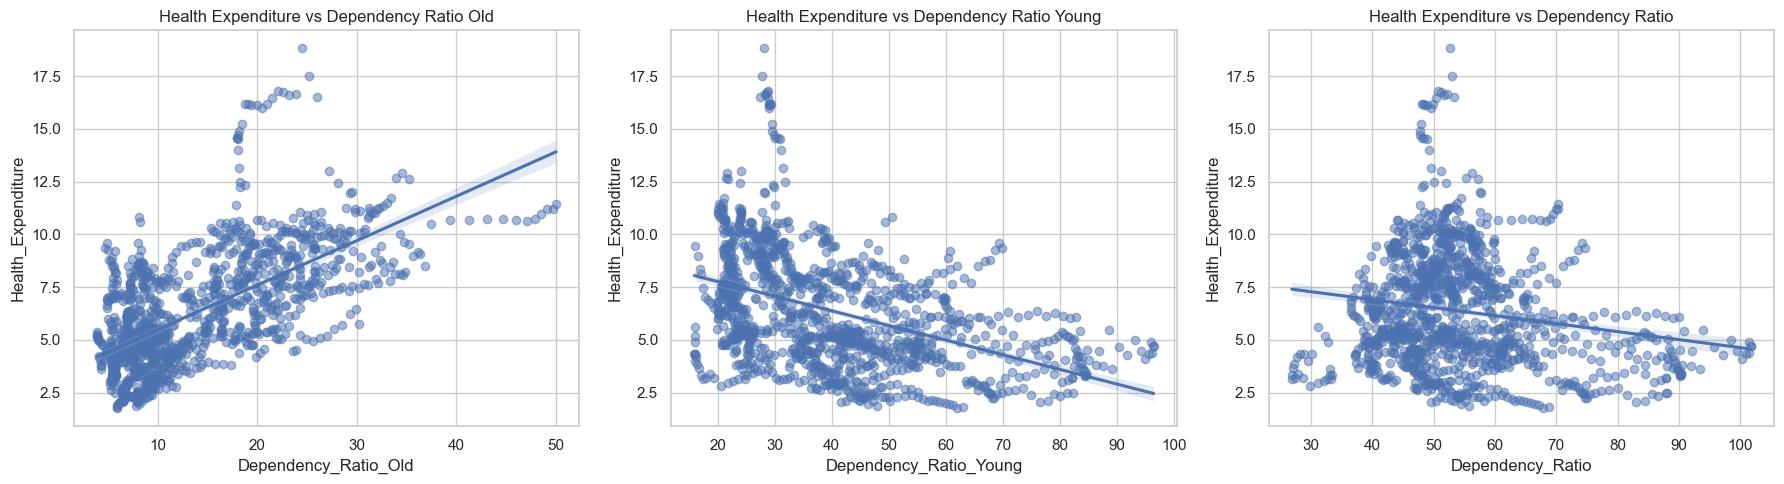

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plotting style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Dependency_Ratio_Old vs Health_Expenditure
sns.regplot(x="Dependency_Ratio_Old", y="Health_Expenditure", data=df_model, ax=axes[0], scatter_kws={'alpha':0.5})
axes[0].set_title("Health Expenditure vs Dependency Ratio Old")

# 2. Dependency_Ratio_Young vs Health_Expenditure
sns.regplot(x="Dependency_Ratio_Young", y="Health_Expenditure", data=df_model, ax=axes[1], scatter_kws={'alpha':0.5})
axes[1].set_title("Health Expenditure vs Dependency Ratio Young")

# 3. log_GDP_percapita vs Health_Expenditure
sns.regplot(x="Dependency_Ratio", y="Health_Expenditure", data=df_model, ax=axes[2], scatter_kws={'alpha':0.5})
axes[2].set_title("Health Expenditure vs Dependency Ratio")

plt.tight_layout()
plt.show()

/var/folders/py/4z0fk4cn3_dcjpjscqzv_9jr0000gn/T/ipykernel_45921/3614318883.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



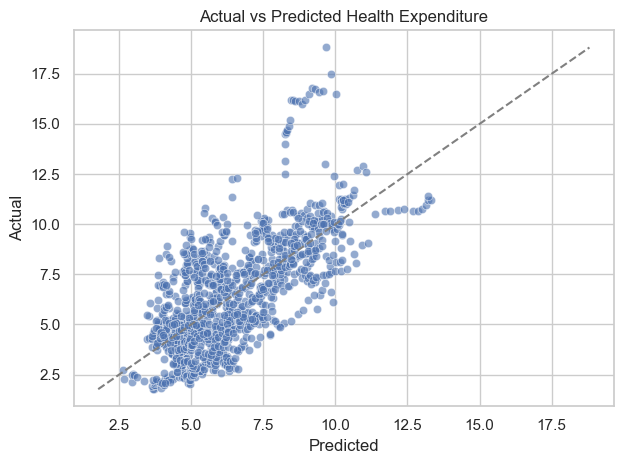

In [18]:
df_model["Predicted"] = model.fittedvalues

sns.scatterplot(x="Predicted", y="Health_Expenditure", data=df_model, alpha=0.6)
plt.plot([df_model["Health_Expenditure"].min(), df_model["Health_Expenditure"].max()],
         [df_model["Health_Expenditure"].min(), df_model["Health_Expenditure"].max()],
         '--', color='gray')
plt.title("Actual vs Predicted Health Expenditure")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


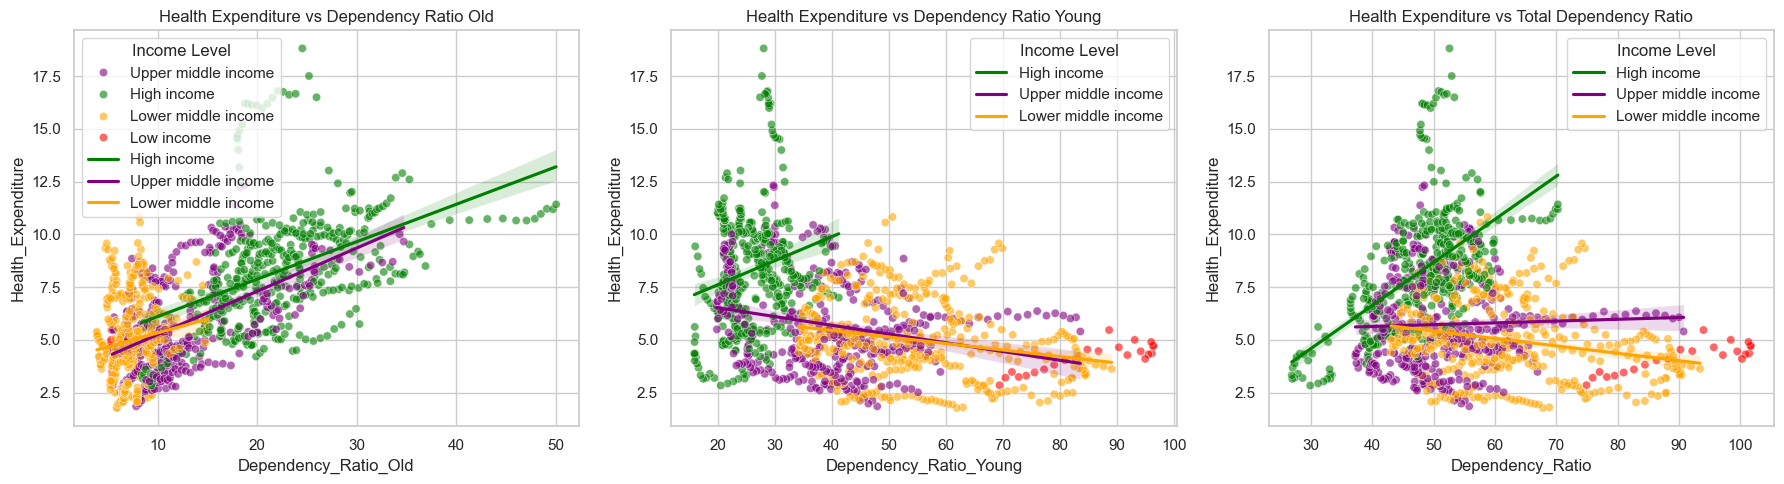

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("../data/interim/merged_data.csv")

# Define custom color palette
custom_palette = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "orange",
    "Low income": "red"
}

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target variables
x_vars = ["Dependency_Ratio_Old", "Dependency_Ratio_Young", "Dependency_Ratio"]
titles = [
    "Health Expenditure vs Dependency Ratio Old",
    "Health Expenditure vs Dependency Ratio Young",
    "Health Expenditure vs Total Dependency Ratio"
]

# Scatter all points + multiple fitted lines by group
for i, x in enumerate(x_vars):
    ax = axes[i]

    # Scatter all groups
    sns.scatterplot(
        x=x, y="Health_Expenditure", hue="income_level", palette=custom_palette,
        data=df, ax=ax, alpha=0.6, legend=(i==0)
    )

    # Add fitted lines for selected income levels
    for group in ["High income", "Upper middle income", "Lower middle income"]:
        subset = df[df["income_level"] == group]
        sns.regplot(
            x=x, y="Health_Expenditure", data=subset, ax=ax,
            scatter=False, color=custom_palette[group], label=group
        )

    ax.set_title(titles[i])
    ax.legend().set_title("Income Level")

plt.tight_layout()
plt.show()


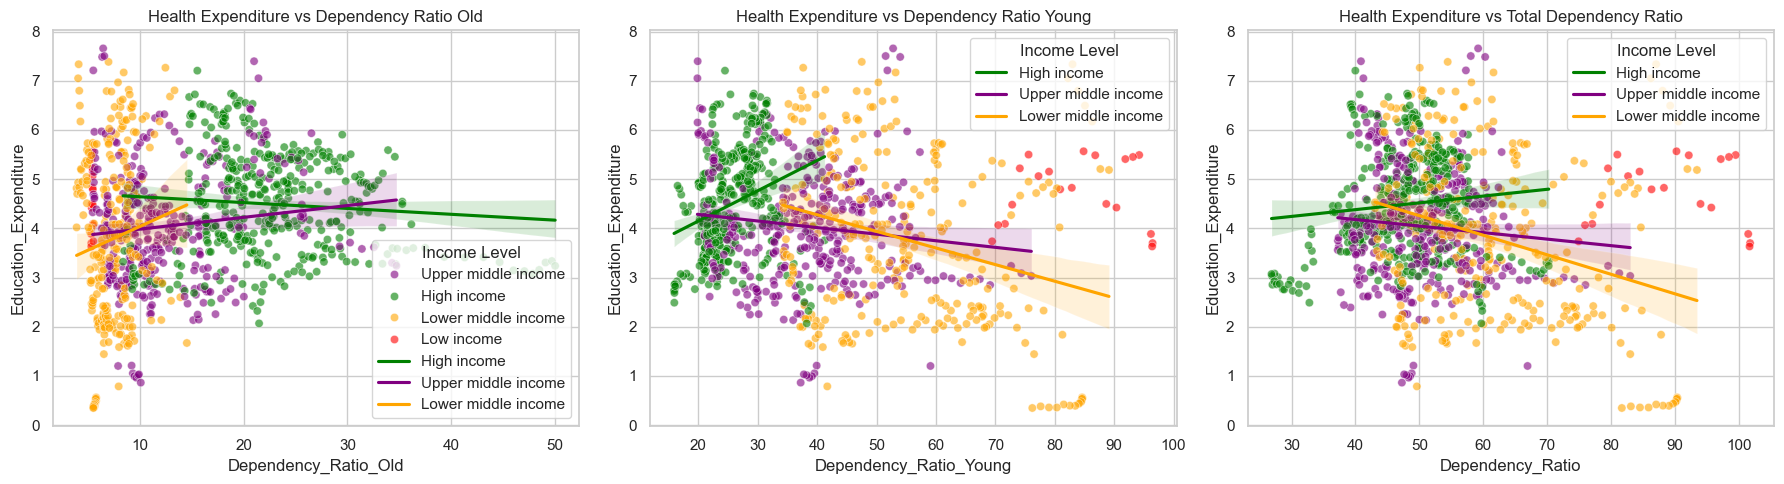

In [30]:
df = pd.read_csv("../data/interim/merged_data.csv")

# Define custom color palette
custom_palette = {
    "High income": "green",
    "Upper middle income": "purple",
    "Lower middle income": "orange",
    "Low income": "red"
}

# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Target variables
x_vars = ["Dependency_Ratio_Old", "Dependency_Ratio_Young", "Dependency_Ratio"]
titles = [
    "Health Expenditure vs Dependency Ratio Old",
    "Health Expenditure vs Dependency Ratio Young",
    "Health Expenditure vs Total Dependency Ratio"
]

# Scatter all points + multiple fitted lines by group
for i, x in enumerate(x_vars):
    ax = axes[i]

    # Scatter all groups
    sns.scatterplot(
        x=x, y="Education_Expenditure", hue="income_level", palette=custom_palette,
        data=df, ax=ax, alpha=0.6, legend=(i==0)
    )

    # Add fitted lines for selected income levels
    for group in ["High income", "Upper middle income", "Lower middle income"]:
        subset = df[df["income_level"] == group]
        sns.regplot(
            x=x, y="Education_Expenditure", data=subset, ax=ax,
            scatter=False, color=custom_palette[group], label=group
        )

    ax.set_title(titles[i])
    ax.legend().set_title("Income Level")

plt.tight_layout()
plt.show()